In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt
from matplotlib.ticker import FixedLocator

In [2]:
a = np.ones((3, 5))
b = np.ones((3, 5))
np.concatenate([a,b], axis=0)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [3]:
np.stack([a,b], axis=0)

array([[[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]])

In [2]:
def load_cv_results(models, base_dir, year=2017, trials=5, ext='', fluxes=False):
    results = dict()
    bird_scales = dict()
    all_fluxes = dict()
    radar_idx = dict()
    
    for i, (m, d) in enumerate(models.items()):

        # load predictions
        model_dir = osp.join(base_dir, m)
        result_list = []
        radar_idx_list = []
        for t in range(1, trials+1):
            file = osp.join(model_dir, f'test_{year}', d, f'trial_{t}', f'results{ext}.csv')
            if osp.isfile(file):
                df = pd.read_csv(file)
                df['trial'] = t
                result_list.append(df)
            
            radar_path = osp.join(osp.dirname(file), 'radar_index.pickle')
            if osp.isfile(radar_path):
                with open(radar_path, 'rb') as f:
                    radar_idx_list.append(pickle.load(f))
        radar_idx[m] = radar_idx_list
        results[m] = pd.concat(result_list)
        
        print(f'successfully loaded results for {m}')
        
        # load fluxes
        if fluxes and 'Flux' in m:
            m_fluxes = [dict(), dict()]
            for t in range(1, trials+1):
                sub_dir = osp.join(model_dir, f'test_{year}', d, f'trial_{t}')
                          
#                 with open(osp.join(sub_dir, f'radar_fluxes{ext}.pickle'), 'rb') as f:
#                     m_fluxes[0][t] = pickle.load(f)
                file = osp.join(sub_dir, f'model_fluxes{ext}.pickle')
                if osp.isfile(file):    
                    with open(osp.join(sub_dir, f'model_fluxes{ext}.pickle'), 'rb') as f:
                        m_fluxes[1][t] = pickle.load(f)
    
            all_fluxes[m] = m_fluxes

    return results, bird_scales, all_fluxes, radar_idx

In [3]:
def compute_rmse(m, results, groupby='fold', threshold=0, km2=True):
    
    ext = '_km2' if km2 else ''
        
    results[f'squared_error{ext}'] = results[f'residual{ext}'].pow(2)
    df = results.query(f'missing == 0 & gt{ext} >= {threshold}')
    rmse = df.groupby(groupby)[f'squared_error{ext}'].aggregate(np.mean).apply(np.sqrt)
    rmse = rmse.reset_index(name='rmse')
    rmse['model'] = m
    
    return rmse

In [4]:
def plot_fluxes(voronoi, G, all_fluxes, results, model=1, context=24, horizon=64, bird_scale=1, 
                net_fluxes=False, abm=False, ax=None, crs=None, max_flux=0, cbar=True):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

#     if abm:
#         f = np.concatenate([f[..., :horizon+1] for f in all_fluxes.values()], axis=-1)
#         mask = np.concatenate([results.query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
#                            for i in range(len(all_fluxes))])
#     else:
    if model:
        f = torch.cat([f for f in all_fluxes.values()], dim=-1).detach().numpy()
    else:
        f = np.concatenate([f[..., context:context+horizon] for f in all_fluxes.values()], axis=-1)
#     mask = np.concatenate([results.query(f'seqID == {i} & horizon > {context}').groupby('horizon').night.all().values 
#                        for i in range(len(all_fluxes))])


    #radars = results.radar.unique()
    radars = voronoi.radar.values

    #f[f == 0] = np.nan
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i]) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j])
#             print(val, val2)
            #print(val)
            if net_fluxes:
                val = val - val2
            if val > 0 and i !=j :
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
#                 if not boundary1 and not boundary2:
#                     print(i, ri, j, rj, val, val2)
                if not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                     observed = voronoi.observed,
                                 geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]), 
                                crs='epsg:4326').to_crs(crs)
    pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
           (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
#     pos = {ridx: (voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for 
#            (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    fluxes *= bird_scale
    edge_widths = np.minimum(fluxes, max_flux) / (0.25 * max_flux) + 0.8

    c_radar = 'lightgray' #'#999999' # '#347B98' '#0a3142' #'#4A7BB7' # '#0086b3'
    c_marker = '#0a3142'
    node_colors = ['#999999' if 'boundary' in n_data['radar'] else c_radar for n, n_data in G_new.nodes(data=True)]
    node_colors = [c_radar for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    
    #max_flux = max(max_flux, fluxes.max())
    norm = plt.Normalize(0, max_flux)
    #print(fluxes.min(), fluxes.max())
    #print(nx.get_edge_attributes(G_new, 'flux'))
    edge_colors = cmap(norm(fluxes))

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=9000/len(G_new), node_color=node_colors, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", 
                  edge_color=edge_colors, width=edge_widths, zorder=2)
#     nx.draw_networkx_edges(G_new, pos=pos, connectionstyle="arc3,rad=0.1", 
#                   edge_color=edge_colors, width=edge_widths)#, arrowsize=edge_widths*100)
    
    gplt.polyplot(coord_df.query('observed == 1').buffer(20_000).to_crs(epsg=4326), ax=ax, extent=extent, zorder=3, edgecolor=c_marker, linewidth=1.5)
    gplt.polyplot(coord_df.query('observed == 0').buffer(20_000).to_crs(epsg=4326), ax=ax, extent=extent, zorder=3, edgecolor=c_marker, linewidth=2)
    gplt.pointplot(coord_df.query('observed == 1').to_crs(epsg=4326), ax=ax, extent=extent, zorder=4, color=c_marker, s=6)


    if cbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        plt.colorbar(sm, extend='max').set_label(label='number of birds',size=15);
    return G_new, ax, max_flux

In [5]:

def compute_mse(model, experiment, results, groupby='trial', threshold=0, km2=True):
    ext = '_km2' if km2 else ''

    results[f'squared_error{ext}'] = results[f'residual{ext}'].pow(2)
    #results[f'squared_error{ext}'] = (results[f'gt{ext}'].apply(lambda x: np.log(x + 0.001)) - results[f'prediction{ext}'].apply(lambda x: np.log(x + 0.001))).pow(2)
    df = results.query(f'missing == 0 & gt{ext} >= {threshold}') # & night == 1')
    mse = df.groupby(groupby)[f'squared_error{ext}'].aggregate(np.mean).apply(np.sqrt)
    mse = mse.reset_index(name='rmse')
    mse['model'] = model
    mse['experiment'] = experiment

    return mse

def compute_pcc(model, experiment, results, groupby='trial', threshold=0, km2=True):
    ext = '_km2' if km2 else ''

    df = results.query(f'missing == 0 & gt{ext} >= {threshold}').dropna() # & night == 1')
    pcc = df.groupby(groupby)[['gt_km2', 'prediction_km2']].corr().iloc[0::2,-1]
    pcc = pcc.reset_index()
    pcc['pcc'] = pcc['prediction_km2']
    pcc['model'] = model
    pcc['experiment'] = experiment

    return pcc

def compute_classification(model, experiment, results, groupby='trial', threshold=0, km2=True):
    ext = '_km2' if km2 else ''

    df = results.query(f'missing == 0').dropna()
    df['tp'] = (df[f'prediction{ext}'] > threshold) & (df[f'gt{ext}'] > threshold)
    df['fp'] = (df[f'prediction{ext}'] > threshold) & (df[f'gt{ext}'] < threshold)
    df['fn'] = (df[f'prediction{ext}'] < threshold) & (df[f'gt{ext}'] > threshold)
    df['tn'] = (df[f'prediction{ext}'] < threshold) & (df[f'gt{ext}'] < threshold)

    gr = df.groupby(groupby).aggregate(sum).reset_index()
    gr['accuracy'] = (gr.tp + gr.tn) / (gr.tp + gr.fp + gr.tn + gr.fn)
    gr['precision'] = gr.tp / (gr.tp + gr.fp)
    gr['sensitivity'] = gr.tp / (gr.tp + gr.fn)
    gr['specificity'] = gr.tn / (gr.tn + gr.fp)
    gr['fscore'] = 2 / ((1 / gr.precision) + (1 / gr.sensitivity))
    
    gr = gr.reset_index()
    gr['model'] = model
    gr['experiment'] = experiment

    return gr


In [6]:
def plot_performance(ax, df, label, metric, color, static=False, H=64, ls='-'):
    
    if static:
        df = df.groupby('trial').aggregate(np.nanmean).reset_index()
        avg = np.array([np.nanmean(df[metric].values)]*H)
        std = np.array([np.nanstd(df[metric].values)]*H)
        #ls = '--'
    else:
        grouped = df.groupby('horizon')        
        avg = grouped[metric].aggregate(np.nanmean).values[-H:]
        std = grouped[metric].aggregate(np.nanstd).values[-H:]
        #ls = '-'
    
    line = ax.plot(range(1,H+1), avg, label=label, ls=ls, color=color, linewidth=1.8)
    ax.fill_between(range(1, H+1), avg-std, avg+std, color=color, alpha=0.2)


In [7]:
base_dir = '/home/fiona/birdMigration/results/abm'
#base_dir = '/media/fiona/Seagate Basic/PhD/paper_1/results/abm'

In [135]:
features = pd.read_csv('/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=25/abm/fall/2017/dynamic_features.csv')

In [139]:
features.columns

Index(['Unnamed: 0', 'radar', 'solarpos_dt', 'solarpos', 'night', 'dusk',
       'dawn', 'datetime', 'dayofyear', 'tidx', 'birds', 'birds_km2', 'bird_u',
       'bird_v', 'birds_from_buffer', 'birds_km2_from_buffer', 'u', 'v', 'u10',
       'v10', 'cc', 'tp', 'sp', 't2m', 'sshf', 'wind_speed', 'wind_dir',
       'nightID', 'acc_rain', 'acc_wind', 'wind_profit', 'missing'],
      dtype='object')

In [146]:
total_birds = features.groupby('tidx').birds.aggregate(sum).reset_index()

def get_month(dts):
    return pd.DatetimeIndex(dts)[0].month
months = features.groupby('tidx').datetime.aggregate(get_month).reset_index()

In [185]:
birds_per_month = {}
N = total_birds.birds.sum()
for m in months.datetime.unique():
    idx = np.where(months.datetime.values == m)
    birds_per_month[m] = total_birds.birds.values[idx].sum() / N

In [186]:
birds_per_month

{8: 0.02640949364516881,
 9: 0.6882809876881161,
 10: 0.17567023526669331,
 11: 0.10963928340002181}

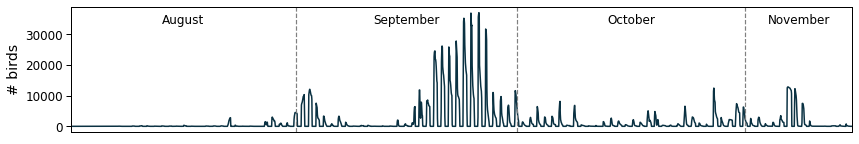

In [182]:
fig, ax = plt.subplots(figsize=(14,2.3))
ax.plot(total_birds.birds.values, lw=1.5, c='#0a3142')
ax.set(xticks=[])
ax.set_ylabel('# birds', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

m = months.datetime.values
switches = np.where(m[1:] - m[:-1] == 1)[0]

prev = 0
month_labels = ['August', 'September', 'October', 'November']
for i, s in enumerate(switches):
    ax.axvline(s+0.5, ls='--', c='gray')
    plt.annotate(month_labels[i], ((prev+s)/2, total_birds.birds.max()*0.9), 
                 xycoords='data', ha='center', fontsize=12)
    prev = s
plt.annotate(month_labels[-1], ((prev+months.tidx.max())/2, total_birds.birds.max()*0.9), 
             xycoords='data', ha='center', fontsize=12)

ax.set_xlim(0, months.tidx.max())
#idx = np.arange(0, months.tidx.max(), 20)
#plt.xticks(months.tidx[idx], months.datetime[idx]);
fig.savefig('/home/fiona/birdMigration/data/plots/final/abm_birds_time_series.png', bbox_inches='tight', dpi=200)

In [161]:
m = months.datetime.values
switch = np.where(m[1:] - m[:-1] == 1)

(array([ 731, 1451, 2195]),)

In [7]:
models = ['GAM', 'LocalMLP', 'LocalLSTM', 'FluxGraphLSTM']
ext = '_fixedT0'
all_rmse = []
all_rmse_per_h = []
for m in models:
    all_rmse.append(pd.read_csv(osp.join(base_dir, f'nested_cv_{m}', 'performance_evaluation', f'rmse_per_fold_thr0{ext}.csv')))
    all_rmse_per_h.append(pd.read_csv(osp.join(base_dir, f'nested_cv_{m}', 'performance_evaluation', f'rmse_per_hour_thr0{ext}.csv')))
df_rmse = pd.concat(all_rmse)
df_rmse_h = pd.concat(all_rmse_per_h)

In [9]:
models = {'FluxRGNN': 'test_no_coords_high_lr'}
r, _, fluxes, ridx = load_cv_results(models, base_dir, ext='_fixedT0', year=2015, fluxes=True, trials=2)

successfully loaded results for FluxRGNN


In [15]:
models = {'FluxRGNN': 'final_without_encoder'}
r, _, fluxes, ridx = load_cv_results(models, base_dir, ext='_fixedT0', fluxes=False, trials=4)

successfully loaded results for FluxRGNN


In [38]:
models = {'GBT': 'final_evaluation'}
r, _, _, ridx = load_cv_results(models, base_dir, ext='_fixedT0', fluxes=False, trials=5)

successfully loaded results for GBT


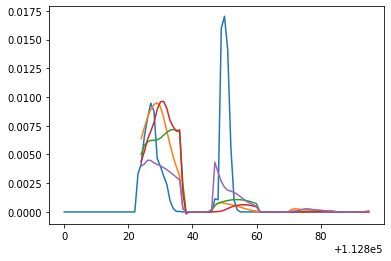

In [17]:
r['FluxRGNN'].query('seqID == 16 & trial == 1 & radar == "dehnr"').gt_km2.plot()
r['FluxRGNN'].query('seqID == 16 & trial == 1 & radar == "dehnr"').prediction_km2.plot()
r['FluxRGNN'].query('seqID == 16 & trial == 2 & radar == "dehnr"').prediction_km2.plot()
r['FluxRGNN'].query('seqID == 16 & trial == 3 & radar == "dehnr"').prediction_km2.plot()
r['FluxRGNN'].query('seqID == 16 & trial == 4 & radar == "dehnr"').prediction_km2.plot()

In [7]:
models = {'FluxGraphLSTM': 'final_evaluation_64_voronoi', 'LocalLSTM': 'final_evaluation_64_voronoi'}
r, _, _, ridx = load_cv_results(models, base_dir, ext='_fixedT0', fluxes=False, trials=3)

successfully loaded results for FluxGraphLSTM
successfully loaded results for LocalLSTM


In [8]:
all_mse = []
all_pcc = []
all_bin = []
for m, d in models.items():
    all_mse.append(compute_mse(m, d, r[m], groupby=['trial', 'horizon'], threshold=0, km2=True))
    all_pcc.append(compute_pcc(m, d, r[m], groupby=['trial', 'horizon'], threshold=0, km2=True))
    #all_bin.append(compute_classification(m, d, r[m], groupby=['trial', 'horizon'], threshold=0.01, km2=True))
rmse_per_hour = pd.concat(all_mse)
pcc_per_hour = pd.concat(all_pcc)
#bin_per_hour = pd.concat(all_bin)

## Ablation experiments
### Root-Mean-Squared Error (RMSE)

In [188]:
rmse_per_hour = pd.read_csv(osp.join(base_dir, 'performance_evaluation', 'ablations', 'rmse_per_hour.csv'))
rmse_per_hour['rmse'] = rmse_per_hour['rmse'] / 0.2643902916959685
grouped = rmse_per_hour.query('horizon == 24').groupby(['model', 'experiment'])
means = grouped.rmse.aggregate(np.nanmean)
stds = grouped.rmse.aggregate(np.nanstd)
print(means, stds)

model      experiment            
FluxRGNN   final                     0.025401
           final_without_boundary    0.026691
           final_without_encoder     0.027016
LocalLSTM  final                     0.028701
Name: rmse, dtype: float64 model      experiment            
FluxRGNN   final                     0.000279
           final_without_boundary    0.000545
           final_without_encoder     0.000683
LocalLSTM  final                     0.000309
Name: rmse, dtype: float64


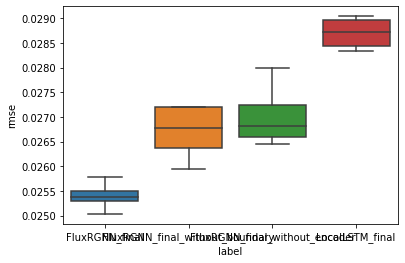

In [23]:
gr = rmse_per_hour.query('horizon == 24').groupby(['model', 'experiment'])
df = []
for group, data in gr:
    data['label'] = f'{group[0]}_{group[1]}'
    df.append(data)
df = pd.concat(df)

sb.boxplot(data=df, x='label', y='rmse');

### Pearson correlation coefficient (PCC)

In [189]:
pcc_per_hour = pd.read_csv(osp.join(base_dir, 'performance_evaluation', 'ablations', 'pcc_per_hour.csv'))
grouped = pcc_per_hour.query('horizon == 24').groupby(['model', 'experiment'])
means = grouped.pcc.aggregate(np.nanmean)
stds = grouped.pcc.aggregate(np.nanstd)
print(means, stds)

model      experiment            
FluxRGNN   final                     0.535150
           final_without_boundary    0.516970
           final_without_encoder     0.447460
LocalLSTM  final                     0.346233
Name: pcc, dtype: float64 model      experiment            
FluxRGNN   final                     0.011738
           final_without_boundary    0.030924
           final_without_encoder     0.031686
LocalLSTM  final                     0.026265
Name: pcc, dtype: float64


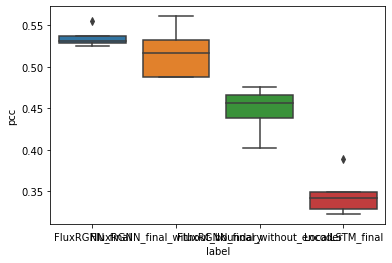

In [28]:
gr = pcc_per_hour.query('horizon == 24').groupby(['model', 'experiment'])
df = []
for group, data in gr:
    data['label'] = f'{group[0]}_{group[1]}'
    df.append(data)
df = pd.concat(df)

sb.boxplot(data=df, x='label', y='pcc');

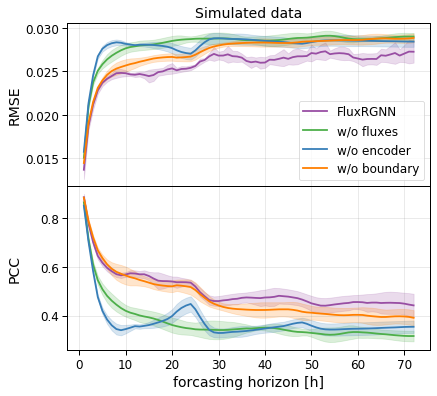

In [193]:
cmap = plt.get_cmap('jet')

models = {('FluxRGNN', 'final'): 'FluxRGNN', 
          ('LocalLSTM', 'final'): 'w/o fluxes',       
          ('FluxRGNN', 'final_without_encoder'): 'w/o encoder',
          ('FluxRGNN', 'final_without_boundary'): 'w/o boundary'}
colors = ['#984ea3', '#4daf4a', '#377eb8', '#ff7f00']
static_models = ['HA', 'GAM', 'GBT']

C = 24
H = 72

fig, ax = plt.subplots(nrows=2, figsize=(6.5,6), sharex=True)

for i, ((m, e), label) in enumerate(models.items()):
    ls = '--' if m in static_models else '-'
    plot_performance(ax[0], rmse_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'rmse', static=(m in static_models), H=H, color=colors[i], ls=ls)
    plot_performance(ax[1], pcc_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'pcc', static=(m in static_models), H=H, color=colors[i], ls=ls)
    
ax[0].set_ylabel('RMSE', fontsize=14)
#ax[0].set_xlabel('forcasting horizon [h]', fontsize=14)
ax[1].set_ylabel('PCC', fontsize=14)
ax[1].set_xlabel('forcasting horizon [h]', fontsize=14)
ax[0].legend(loc='lower right', fontsize=12)
ax[0].set_title('Simulated data', fontsize=14)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)

fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
#fig.savefig('/home/fiona/birdMigration/data/plots/final/radar_rmse_pcc_per_hour_final.png', bbox_inches='tight', dpi=200)

### Binary classification metrics
1. Precision

In [48]:
bin_per_hour = pd.read_csv(osp.join(base_dir, 'performance_evaluation', 'ablations', 'bin_per_hour.csv'))
thr = bin_per_hour.threshold.unique()[1]
grouped = bin_per_hour.query(f'horizon == 24 & threshold == {thr}').groupby(['model', 'experiment'])
means = grouped.precision.aggregate(np.nanmean)
stds = grouped.precision.aggregate(np.nanstd)
print(means, stds)

model      experiment            
FluxRGNN   final                     0.584586
           final_without_boundary    0.517808
           final_without_encoder     0.455439
LocalLSTM  final                     0.418330
Name: precision, dtype: float64 model      experiment            
FluxRGNN   final                     0.000000
           final_without_boundary    0.025477
           final_without_encoder     0.024477
LocalLSTM  final                     0.019118
Name: precision, dtype: float64


2. Sensitivity

In [49]:
thr = bin_per_hour.threshold.unique()[1]
grouped = bin_per_hour.query(f'horizon == 24 & threshold == {thr}').groupby(['model', 'experiment'])
means = grouped.sensitivity.aggregate(np.nanmean)
stds = grouped.sensitivity.aggregate(np.nanstd)
print(means, stds)

model      experiment            
FluxRGNN   final                     0.280813
           final_without_boundary    0.240418
           final_without_encoder     0.207449
LocalLSTM  final                     0.152144
Name: sensitivity, dtype: float64 model      experiment            
FluxRGNN   final                     0.000000
           final_without_boundary    0.021392
           final_without_encoder     0.039634
LocalLSTM  final                     0.018732
Name: sensitivity, dtype: float64


## Comparison to baseline models

In [49]:
rmse_per_hour = pd.read_csv(osp.join(base_dir, 'performance_evaluation', 'final', 'rmse_per_hour.csv'))
pcc_per_hour = pd.read_csv(osp.join(base_dir, 'performance_evaluation', 'final', 'pcc_per_hour.csv'))
bin_per_hour = pd.read_csv(osp.join(base_dir, 'performance_evaluation', 'final', 'bin_per_hour.csv'))

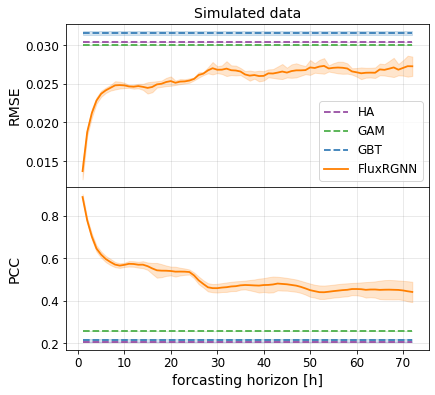

In [50]:
cmap = plt.get_cmap('jet')

models = {'HA': '#984ea3', 'GAM': '#4daf4a', 'GBT': '#377eb8', 'FluxRGNN': '#ff7f00'}
static_models = ['HA', 'GAM', 'GBT']

C = 24
H = 72

bscale = 0.2643902916959686
rmse_per_hour['rmse'] /= bscale

fig, ax = plt.subplots(nrows=2, figsize=(6.5,6), sharex=True)

for i, (m, c) in enumerate(models.items()):
    ls = '--' if m in static_models else '-'
    plot_performance(ax[0], rmse_per_hour.query(f'model == "{m}"'), 
                     m, 'rmse', static=(m in static_models), H=H, color=c, ls=ls)
    plot_performance(ax[1], pcc_per_hour.query(f'model == "{m}"'), 
                     m, 'pcc', static=(m in static_models), H=H, color=c, ls=ls)
    
ax[0].set_ylabel('RMSE', fontsize=14)
#ax[0].set_xlabel('forcasting horizon [h]', fontsize=14)
ax[1].set_ylabel('PCC', fontsize=14)
ax[1].set_xlabel('forcasting horizon [h]', fontsize=14)
ax[0].legend(loc='lower right', fontsize=12)
ax[0].set_title('Simulated data', fontsize=14)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)
    
    
fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
fig.savefig('/home/fiona/birdMigration/data/plots/final/abm_rmse_pcc_per_hour_final.png', bbox_inches='tight', dpi=200)

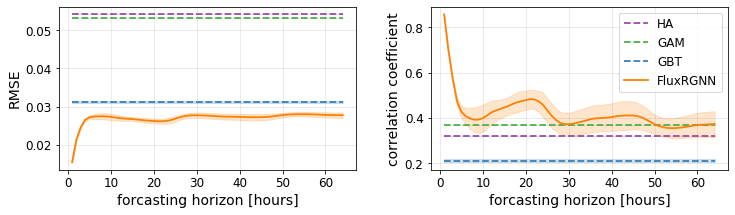

In [22]:
cmap = plt.get_cmap('jet')

models = {'HA': 1, 'GAM': 1, 'GBT': 1, 'FluxGraphLSTM': 0}
labels = ['HA', 'GAM', 'GBT', 'FluxRGNN']
colors = ['#984ea3', '#4daf4a', '#377eb8', '#ff7f00']
#ls = [':', '--', '-.', '-']
ls = ['--', '--', '--', '-']

C = 24
H = 64

bscale = 0.2643902916959686

rmse_per_hour['rmse'] /= bscale

fig, ax = plt.subplots(ncols=2, figsize=(12,3), sharex=True)

for i, (m, static) in enumerate(models.items()):
    plot_performance(ax[0], rmse_per_hour.query(f'model == "{m}"'), 
                     labels[i], 'rmse', static=static, H=H, color=colors[i], ls=ls[i])
    plot_performance(ax[1], pcc_per_hour.query(f'model == "{m}"'), 
                     labels[i], 'pcc', static=static, H=H, color=colors[i], ls=ls[i])
    
ax[1].legend(loc='upper right', fontsize=12)
ax[0].set_ylabel('RMSE', fontsize=14)
ax[0].grid(color = 'gray', linestyle = '-', alpha=0.2)
ax[0].set_xlabel('forcasting horizon [hours]', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_ylabel('correlation coefficient', fontsize=14)
ax[1].grid(color = 'gray', linestyle = '-', alpha=0.2)
ax[1].set_xlabel('forcasting horizon [hours]', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)
fig.subplots_adjust(wspace=0.25)
fig.align_ylabels(ax)
#fig.savefig('/home/fiona/birdMigration/data/plots/final/rmse_pcc_per_hour.png', bbox_inches='tight', dpi=200)

## Evaluation of migratory fluxes

In [137]:
# path = osp.join(base_dir, 'FluxGraphLSTM', 'test_2017', 'test_new_weight_func_split_delta', 'performance_evaluation', 'H=12')
# corr_d2b = pd.read_csv(osp.join(path, 'corr_d2b_per_trial.csv'))
# corr_angles = pd.read_csv(osp.join(path, 'corr_angles_per_trial.csv'))
# bins_per_trial = pd.read_csv(osp.join(path, 'bins_per_trial.csv'))

In [60]:
path = osp.join(base_dir, 'FluxRGNN', 'test_2017', 'final', 'performance_evaluation', '1-24')
corr_d2b = pd.read_csv(osp.join(path, 'agg_corr_d2b_per_trial.csv'))
corr_angles = pd.read_csv(osp.join(path, 'agg_corr_angles_per_trial.csv'))
bins_per_trial = pd.read_csv(osp.join(path, 'agg_bins_per_trial.csv'))

with open(osp.join(path, 'agg_overall_corr.pickle'), 'rb') as f:
    overall_corr = pickle.load(f)

In [61]:
mean_corr = np.mean(list(overall_corr.values()))
std_corr = np.std(list(overall_corr.values()))
print(f'overall correlation = {mean_corr} +/- {std_corr}')

overall correlation = 0.5794126287451336 +/- 0.009119940355229892


In [62]:
mean_acc = bins_per_trial.accuracy.mean()
std_acc = bins_per_trial.accuracy.std()
print(f'overall accuracy of directions = {mean_acc} +/- {std_acc}')

overall accuracy of directions = 0.8702291831041917 +/- 0.007244720459744943


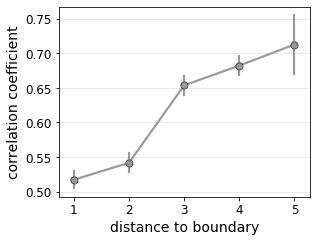

In [63]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
kws = {"s": 70, "facecolor": "none", "linewidth": 1.5}
rc = {'lines.linewidth': 1.2}
sb.set_context('paper', rc=rc)
sb.pointplot(x='d2b', y='corr', data=corr_d2b.dropna(), ax=ax, 
           color='#999999', ci='sd')
means = corr_d2b.groupby('d2b').aggregate(np.nanmean)['corr']
ax.scatter(range(5), means, s=50, edgecolors='#404040', facecolors='#999999', zorder=3)
ax.set_xlabel('distance to boundary', fontsize=14)
ax.set_ylabel('correlation coefficient', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y')
#fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_agg_fluxes_per_d2b_trial_std_points.png', bbox_inches='tight', dpi=200)

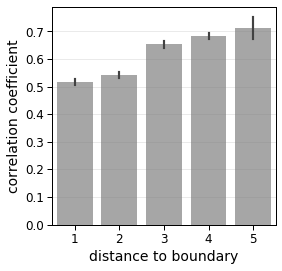

In [67]:
fig, ax = plt.subplots(figsize=(4,4))
sb.barplot(x='d2b', y='corr', data=corr_d2b.dropna(), ax=ax, 
           color='#a6a6a6')#,
          #flierprops=dict(marker="o", markersize=2))
ax.set_xlabel('distance to boundary', fontsize=14)
ax.set_ylabel('correlation coefficient', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y')

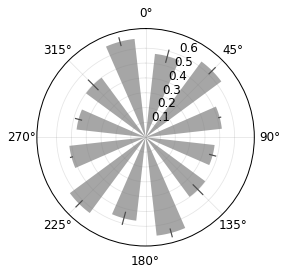

In [64]:
fig, ax = plt.subplots(figsize=(4,4), subplot_kw={'projection': 'polar'})
grouped = corr_angles.groupby('rad')
means = grouped.aggregate(np.nanmean).reset_index()
stds = grouped.aggregate(np.nanstd).reset_index()
bars = ax.bar(means['rad'], means['corr'], width=0.3, bottom=0, 
             yerr=stds['corr'], ecolor='#4d4d4d', color='#a6a6a6')
# max_corr = np.nanmax(means['corr'].values) + np.nanmax(stds['corr'])
# print(max_corr)
# ax.set_rlim(0, max_corr)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.grid(color='gray', linestyle='-', alpha=0.2)
#fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_agg_fluxes_per_angle_trial_std.png', bbox_inches='tight', dpi=200)

In [68]:
path = osp.join(base_dir, 'FluxGraphLSTM', 'test_2017', 'final_evaluation_64', 'performance_evaluation', 'H=24')
corr_d2b = pd.read_csv(osp.join(path, 'agg_corr_d2b_per_trial.csv'))
corr_angles = pd.read_csv(osp.join(path, 'agg_corr_angles_per_trial.csv'))
bins_per_trial = pd.read_csv(osp.join(path, 'agg_bins_per_trial.csv'))

with open(osp.join(path, 'agg_overall_corr.pickle'), 'rb') as f:
    overall_corr = pickle.load(f)

In [69]:
np.mean(list(overall_corr.values())), np.std(list(overall_corr.values()))

(0.46876604089999807, 0.03579565864213654)

In [70]:
bins_per_trial.accuracy.mean(), bins_per_trial.accuracy.std()

(0.8578986453453471, 0.010359693383477626)

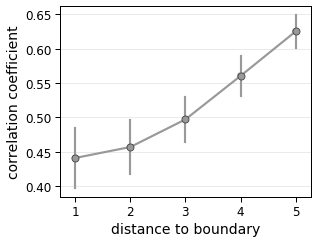

In [149]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
kws = {"s": 70, "facecolor": "none", "linewidth": 1.5}
rc = {'lines.linewidth': 1.2}
sb.set_context('paper', rc=rc)
sb.pointplot(x='d2b', y='corr', data=corr_d2b.dropna(), ax=ax, 
           color='#999999', ci='sd')#,
          #flierprops=dict(marker="o", markersize=2))
means = corr_d2b.groupby('d2b').aggregate(np.nanmean)['corr']
ax.scatter(range(5), means, s=50, edgecolors='#404040', facecolors='#999999', zorder=3)
ax.set_xlabel('distance to boundary', fontsize=14)
ax.set_ylabel('correlation coefficient', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y')
fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_agg_fluxes_per_d2b_trial_std_points.png', bbox_inches='tight', dpi=200)

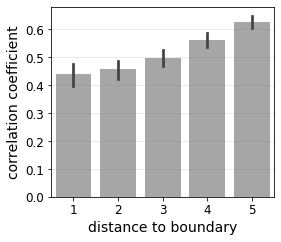

In [73]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
sb.barplot(x='d2b', y='corr', data=corr_d2b.dropna(), ax=ax, 
           color='#a6a6a6')#,
          #flierprops=dict(marker="o", markersize=2))
ax.set_xlabel('distance to boundary', fontsize=14)
ax.set_ylabel('correlation coefficient', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y')
fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_agg_fluxes_per_d2b_trial_std.png', bbox_inches='tight', dpi=200)

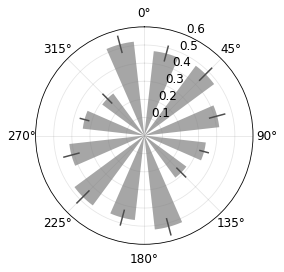

In [66]:
fig, ax = plt.subplots(figsize=(4,4), subplot_kw={'projection': 'polar'})
#grouped = corr_angles.groupby('rad_bin')
grouped = corr_angles.groupby('rad')
means = grouped.aggregate(np.nanmean).reset_index()
stds = grouped.aggregate(np.nanstd).reset_index()
bars = ax.bar(means['rad'], means['corr'], width=0.3, bottom=0, 
             yerr=stds['corr'], ecolor='#4d4d4d', color='#a6a6a6')
max_corr = means['corr'].max() + stds['corr'].max()
ax.set_rlim(0, max_corr)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.grid(color='gray', linestyle='-', alpha=0.2)
fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_agg_fluxes_per_angle_trial_std.png', bbox_inches='tight', dpi=200)

In [166]:
path = osp.join(base_dir, 'FluxGraphLSTM', 'test_2017', 'final_evaluation_64', 'performance_evaluation', 'H=24')
corr_d2b = pd.read_csv(osp.join(path, 'corr_d2b_per_trial.csv'))
corr_angles = pd.read_csv(osp.join(path, 'corr_angles_per_trial.csv'))
bins_per_trial = pd.read_csv(osp.join(path, 'bins_per_trial.csv'))

with open(osp.join(path, 'overall_corr.pickle'), 'rb') as f:
    overall_corr = pickle.load(f)

In [214]:
np.mean(list(overall_corr.values())), np.std(list(overall_corr.values()))

(0.27503111278733455, 0.026990931020217702)

In [213]:
bins_per_trial.accuracy.mean(), bins_per_trial.accuracy.std()

(0.8652806538004916, 0.012475156467531)

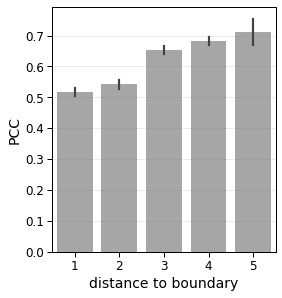

In [118]:
fig, ax = plt.subplots(figsize=(4,4.5))
sb.barplot(x='d2b', y='corr', data=corr_d2b.dropna(), ax=ax, 
           color='#a6a6a6', ci='sd')#,
          #flierprops=dict(marker="o", markersize=2))
ax.set_xlabel('distance to boundary', fontsize=14)
ax.set_ylabel('PCC', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y')
fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_acc_fluxes_per_d2b_trial_std.png', bbox_inches='tight', dpi=200)

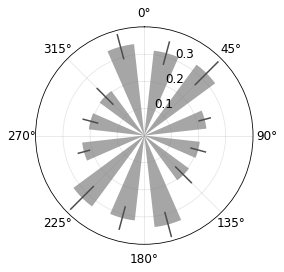

In [211]:
fig, ax = plt.subplots(figsize=(4,4), subplot_kw={'projection': 'polar'})
#grouped = corr_angles.groupby('rad_bin')
grouped = corr_angles.groupby('rad')
means = grouped.aggregate(np.nanmean).reset_index()
stds = grouped.aggregate(np.nanstd).reset_index()
bars = ax.bar(means['rad'], means['corr'], width=0.3, bottom=0, 
             yerr=stds['corr'], ecolor='#4d4d4d', color='#a6a6a6')
max_corr = means['corr'].max() + stds['corr'].max()
ax.set_rlim(0, max_corr)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_yticks([0.1, 0.2, 0.3])
plt.grid(color='gray', linestyle='-', alpha=0.2)
fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_fluxes_per_angle_trial_std.png', bbox_inches='tight', dpi=200)

## Evaluation of source/sink terms

In [54]:
path = osp.join(base_dir, 'FluxRGNN', 'test_2017', 'final', 'performance_evaluation', '1-24')
corr_source = pd.read_csv(osp.join(path, 'agg_source_corr_per_trial.csv'))
corr_sink = pd.read_csv(osp.join(path, 'agg_sink_corr_per_trial.csv'))

In [56]:
corr_source['type'] = 'source'
corr_sink['type'] = 'sink'

In [57]:
source_sink = pd.concat([corr_source[['trial', 'corr', 'type', 'month']], corr_sink[['trial', 'corr', 'type', 'month']]])

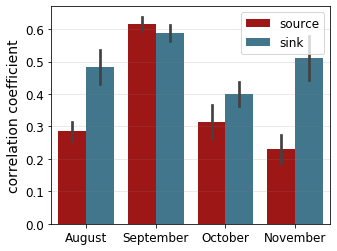

In [58]:
palette = {"source": "#B50000", "sink": "#347B98"}
fig, ax = plt.subplots(figsize=(5,4))
sb.barplot(data=source_sink, x='month', hue='type', y='corr', ax=ax,
           palette=palette, ci='sd')
ax.set_ylabel('correlation coefficient', fontsize=14)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticklabels(['August', 'September', 'October', 'November'])
ax.legend(loc='upper right', fontsize=12)
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y');
#fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_source_sink_per_month_trial_std.png', bbox_inches='tight', dpi=200)

In [68]:
path = osp.join(base_dir, 'FluxRGNN', 'test_2017', 'final', 'performance_evaluation', '1-24')
corr_source = pd.read_csv(osp.join(path, 'agg_source_corr_per_trial.csv'))
corr_sink = pd.read_csv(osp.join(path, 'agg_sink_corr_per_trial.csv'))
corr_influx = pd.read_csv(osp.join(path, 'agg_corr_influx_per_month.csv'))
corr_outflux = pd.read_csv(osp.join(path, 'agg_corr_outflux_per_month.csv'))

corr_sink['type'] = 'sink'
corr_source['type'] = 'source'
corr_influx['type'] = 'influx'
corr_outflux['type'] = 'outflux'

all_corr = pd.concat([corr_source[['trial', 'corr', 'type', 'month']], 
                      corr_sink[['trial', 'corr', 'type', 'month']],
                     corr_influx[['trial', 'corr', 'type', 'month']],
                     corr_outflux[['trial', 'corr', 'type', 'month']]])

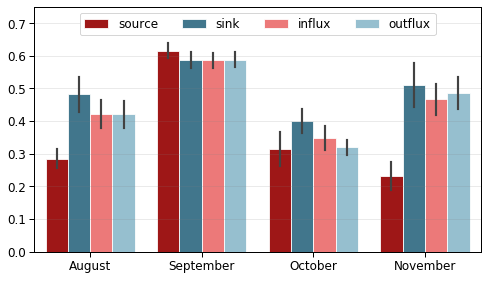

In [114]:
palette = {"source": "#B50000", "sink": "#347B98", "influx": "#ff6666", "outflux": "#8dc3d8"}
fig, ax = plt.subplots(figsize=(8,4.5))
sb.barplot(data=all_corr, x='month', hue='type', y='corr', ax=ax,
           palette=palette, ci='sd', edgecolor="white")
ax.set_ylabel('')
ax.set_xlabel(' ', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticklabels(['August', 'September', 'October', 'November'])
#ax.legend(loc='upper left', fontsize=12)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(all_corr.type.unique()), framealpha=1, fontsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=len(all_corr.type.unique()), framealpha=1, fontsize=12)
ax.set(ylim=(0, 0.75))
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y');
fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_agg_source_sink_fluxes_per_month_trial_std_final.png', bbox_inches='tight', dpi=200)

In [28]:
path = osp.join(base_dir, 'FluxGraphLSTM', 'test_2017', 'final_evaluation_64', 'performance_evaluation', 'H=24')
corr_source = pd.read_csv(osp.join(path, 'agg_source_corr_per_trial.csv'))
corr_sink = pd.read_csv(osp.join(path, 'agg_sink_corr_per_trial.csv'))
corr_influx = pd.read_csv(osp.join(path, 'agg_corr_influx_per_month.csv'))
corr_outflux = pd.read_csv(osp.join(path, 'agg_corr_outflux_per_month.csv'))

In [29]:
corr_sink['type'] = 'sink'
corr_source['type'] = 'source'
corr_influx['type'] = 'influx'
corr_outflux['type'] = 'outflux'

In [30]:
all_corr = pd.concat([corr_source[['trial', 'corr', 'type', 'month']], 
                      corr_sink[['trial', 'corr', 'type', 'month']],
                     corr_influx[['trial', 'corr', 'type', 'month']],
                     corr_outflux[['trial', 'corr', 'type', 'month']]])

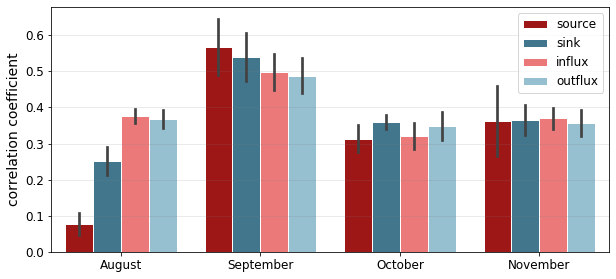

In [40]:
palette = {"source": "#B50000", "sink": "#347B98", "influx": "#ff6666", "outflux": "#8dc3d8"}
fig, ax = plt.subplots(figsize=(10,4.5))
sb.barplot(data=all_corr, x='month', hue='type', y='corr', ax=ax,
           palette=palette, ci='sd', edgecolor="white")
ax.set_ylabel('correlation coefficient', fontsize=14)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticklabels(['August', 'September', 'October', 'November'])
ax.legend(loc='upper right', fontsize=12)
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y');
fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_agg_source_sink_fluxes_per_month_trial_std.png', bbox_inches='tight', dpi=200)

In [55]:
source_sink = pd.concat([corr_source[['trial', 'corr', 'type', 'month']], corr_sink[['trial', 'corr', 'type', 'month']]])

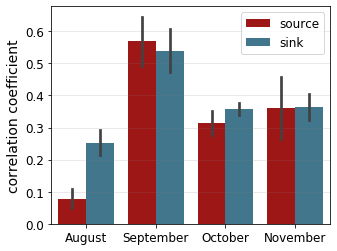

In [67]:
palette = {"source": "#B50000", "sink": "#347B98"}
fig, ax = plt.subplots(figsize=(5,4))
sb.barplot(data=source_sink, x='month', hue='type', y='corr', ax=ax,
           palette=palette, ci='sd')
ax.set_ylabel('correlation coefficient', fontsize=14)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticklabels(['August', 'September', 'October', 'November'])
ax.legend(loc='upper right', fontsize=12)
plt.grid(color='gray', linestyle='-', alpha=0.2, axis='y');
fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_agg_source_sink_per_month_trial_std.png', bbox_inches='tight', dpi=200)

## Importance Sampling

In [16]:
b2015 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2015', 'birds_per_seq.npy'))
b2016 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2016', 'birds_per_seq.npy'))
b2017 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2017', 'birds_per_seq.npy'))

idx2015 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2015', 'resampling_idx.npy'))
idx2016 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2016', 'resampling_idx.npy'))
idx2017 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2017', 'resampling_idx.npy'))

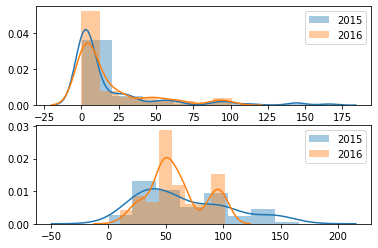

In [167]:
fig, ax = plt.subplots(2, 1)
sb.distplot(b2015, bins=8, ax=ax[0], label='2015')
sb.distplot(b2016, bins=8, ax=ax[0], label='2016')
ax[0].legend()

sb.distplot(b2015[idx2015], bins=8, ax=ax[1], label='2015')
sb.distplot(b2016[idx2016], bins=8, ax=ax[1], label='2016')
ax[1].legend();

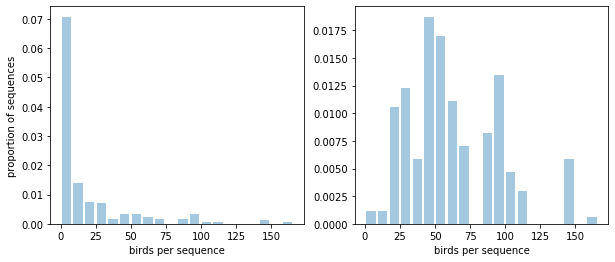

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sb.distplot(np.concatenate([b2015, b2016]), ax=ax[0], bins=20, kde=False, norm_hist=True, hist_kws=dict(rwidth=0.8))
ax[0].set(xlabel='birds per sequence', ylabel='proportion of sequences')

sb.distplot(np.concatenate([b2015[idx2015], b2016[idx2016]]), ax=ax[1], bins=20, kde=False, norm_hist=True, hist_kws=dict(rwidth=0.8))
ax[1].set(xlabel='birds per sequence');
fig.savefig('/home/fiona/birdMigration/data/plots/final/supplementary/importance_sampling.png', bbox_inches='tight', dpi=200)

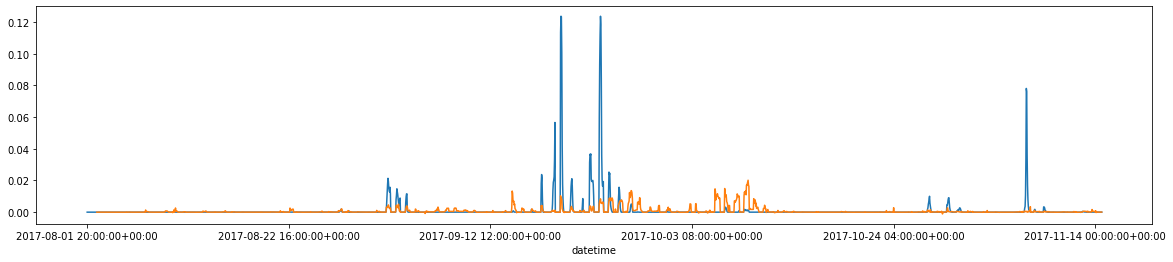

In [40]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'deess'
r['GBT'].query(f'radar == "{radar}"').groupby('datetime').gt_km2.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['GBT'].query(f'radar == "{radar}"').groupby('datetime').prediction_km2.aggregate(np.nanmean).plot(ax=ax, label='Flux')

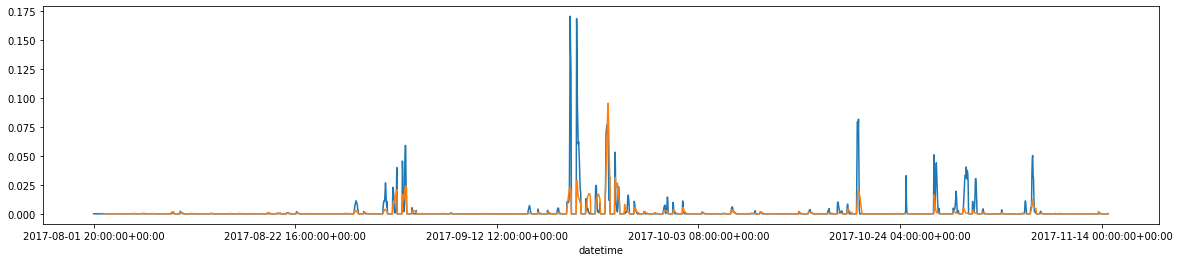

In [25]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'defbg'
r['FluxRGNN'].query(f'radar == "{radar}" & trial == 1').groupby('datetime').gt_km2.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['FluxRGNN'].query(f'radar == "{radar}"').groupby('datetime').prediction_km2.aggregate(np.nanmean).plot(ax=ax, label='Flux')

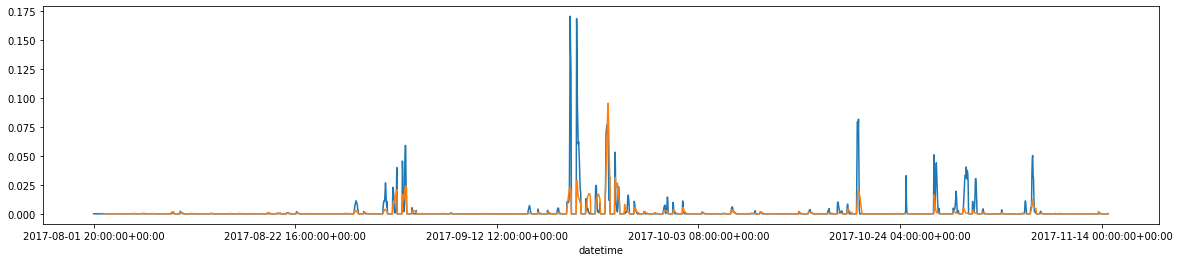

In [26]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'defbg'
r['FluxRGNN'].query(f'radar == "{radar}" & trial == 2').groupby('datetime').gt_km2.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['FluxRGNN'].query(f'radar == "{radar}"').groupby('datetime').prediction_km2.aggregate(np.nanmean).plot(ax=ax, label='Flux')

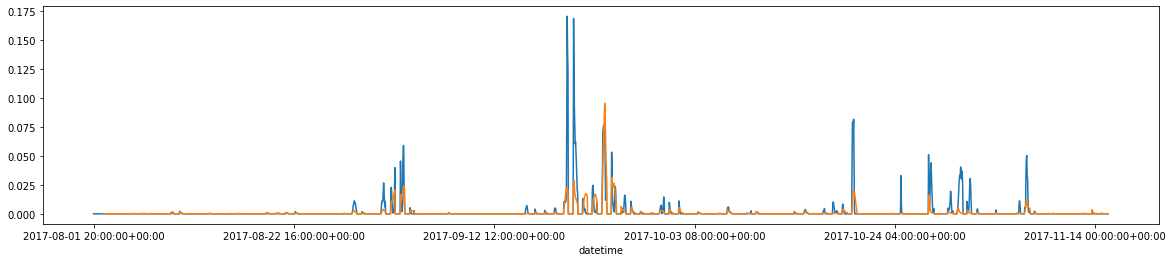

In [13]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'defbg'
r['FluxRGNN'].query(f'radar == "{radar}"').groupby('datetime').gt_km2.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['FluxRGNN'].query(f'radar == "{radar}"').groupby('datetime').prediction_km2.aggregate(np.nanmean).plot(ax=ax, label='Flux')

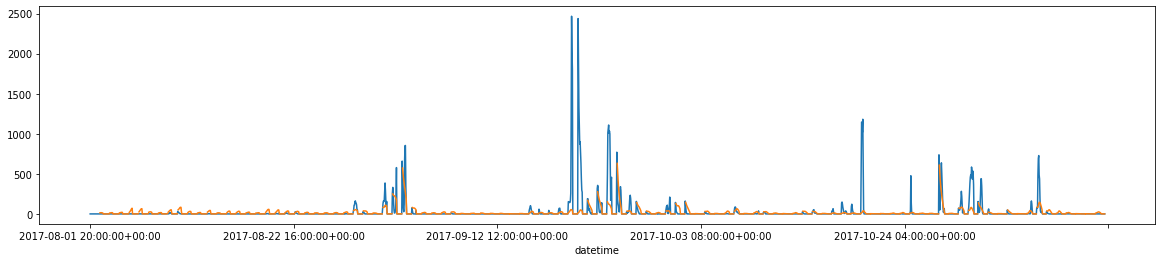

In [80]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'defbg'
r['LocalLSTM'].query(f'radar == "{radar}" & horizon < 24').groupby('datetime').gt.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['LocalLSTM'].query(f'radar == "{radar}" & horizon < 24').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='Flux')

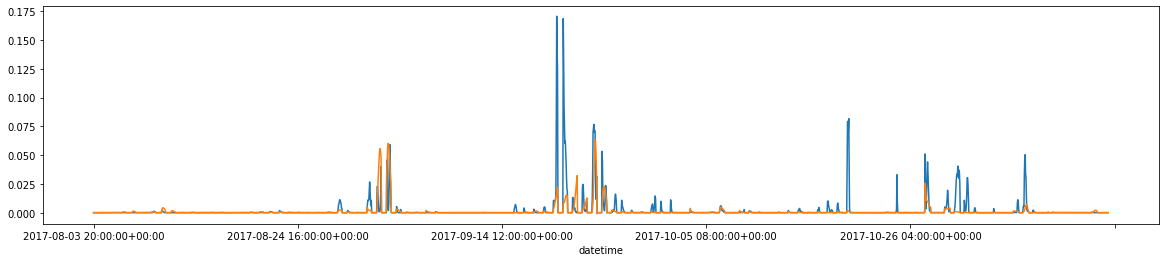

In [83]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'defbg'
r['FluxGraphLSTM'].query(f'radar == "{radar}" & horizon > 24').groupby('datetime').gt_km2.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['FluxGraphLSTM'].query(f'radar == "{radar}" & horizon > 24').groupby('datetime').prediction_km2.aggregate(np.nanmean).plot(ax=ax, label='Flux')

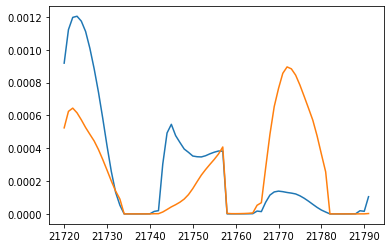

In [37]:
r['FluxRGNN'].query('seqID == 3 & radar == "dehnr" & trial == 1').prediction_km2.plot()
r['FluxRGNN'].query('seqID == 3 & radar == "dehnr" & trial == 2').prediction_km2.plot()

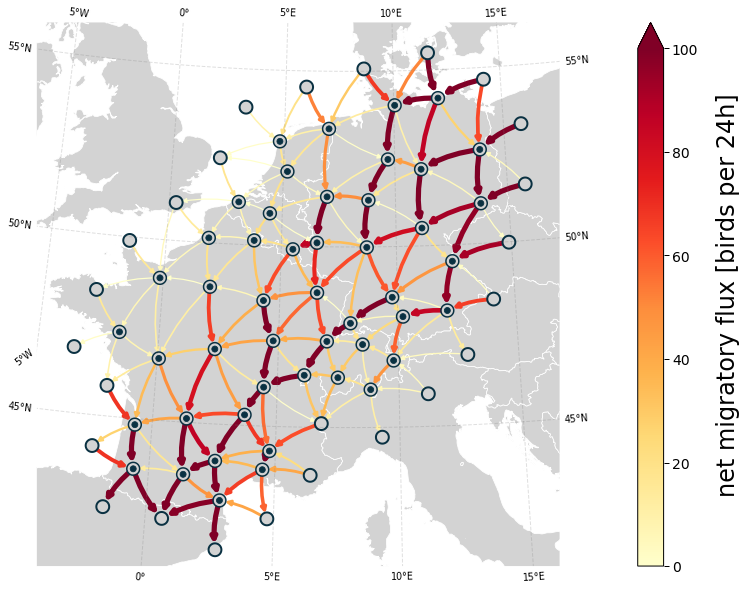

In [134]:
m = 'FluxRGNN'

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["DejaVu Sans"], #["Helvetica"],
#     "font.size": 12})

prep_dir = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=25/abm/fall/2017'
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values


d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw = {'projection' : crs})
extent = [-4, 16, 41, 56]
ax.set_extent(extent)
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)

all_G = {}
trial = 3
for t in [trial]: #range(1, 6):
    all_G[t] = nx.read_gpickle(osp.join(base_dir, m, 'test_2017', 'final', 'performance_evaluation', '1-24', f'model_fluxes_{t}.gpickle'))

G_new = nx.DiGraph()
G_new.add_nodes_from(list(all_G[trial].nodes(data=True)))  
for i, j in it.combinations(list(G_new.nodes()), 2):
    fluxes_ij = []
    fluxes_ji = []
    for t, G in all_G.items():
        data_ij = G.get_edge_data(i, j, default=None)
        data_ji = G.get_edge_data(j, i, default=None)
        if data_ij is not None:
            fluxes_ij.append(data_ij['flux'])
            fluxes_ji.append(-data_ij['flux'])
        if data_ji is not None:
            fluxes_ij.append(-data_ji['flux'])
            fluxes_ji.append(data_ji['flux'])
    if len(fluxes_ij):
        f_ij = np.nanmean(fluxes_ij)
        f_ji = np.nanmean(fluxes_ji)
        if f_ij > 0:
            G_new.add_edge(i, j, flux=f_ij)
        else:
            G_new.add_edge(j, i, flux=f_ji)
    
crs=crs.proj4_init
max_flux = 100
bird_scale = 1
cbar = True

coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                     observed = voronoi.observed,
                                 geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]), 
                                crs='epsg:4326').to_crs(crs)
pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
       (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
#     pos = {ridx: (voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for 
#            (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
fluxes *= bird_scale
edge_widths = np.minimum(fluxes, max_flux) / (0.25 * max_flux) + 1.2

c_radar = 'lightgray' #'#999999' # '#347B98' '#0a3142' #'#4A7BB7' # '#0086b3'
c_marker = '#0a3142'
node_colors = ['#999999' if 'boundary' in n_data['radar'] else c_radar for n, n_data in G_new.nodes(data=True)]
node_colors = [c_radar for n, n_data in G_new.nodes(data=True)]

cmap = cm.get_cmap('YlOrRd')

norm = plt.Normalize(0, max_flux)
edge_colors = cmap(norm(fluxes))


nx.draw(G_new, pos=pos, with_labels=False, node_size=9000/len(G_new), node_color=node_colors, ax=ax, 
        options={'arrowsize': edge_widths*200}, connectionstyle="arc3,rad=0.1", 
              edge_color=edge_colors, width=edge_widths, zorder=2)
#     nx.draw_networkx_edges(G_new, pos=pos, connectionstyle="arc3,rad=0.1", 
#                   edge_color=edge_colors, width=edge_widths)#, arrowsize=edge_widths*100)

gplt.polyplot(coord_df.query('observed == 1').buffer(20_000).to_crs(epsg=4326), ax=ax, extent=extent, zorder=3, edgecolor=c_marker, linewidth=1.5)
gplt.polyplot(coord_df.query('observed == 0').buffer(20_000).to_crs(epsg=4326), ax=ax, extent=extent, zorder=3, edgecolor=c_marker, linewidth=2)
gplt.pointplot(coord_df.query('observed == 1').to_crs(epsg=4326), ax=ax, extent=extent, zorder=4, color=c_marker, s=6)


if cbar:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, extend='max', pad=0.1)
    cbar.set_label(label=r'net migratory flux [birds per 24h]',size=24, labelpad=18)
    cbar.ax.tick_params(labelsize=14) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing

ax.set_extent(extent)

#fig.tight_layout()

fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', f'abm_avg_inferred_24h_fluxes_trial{trial}.png'), bbox_inches='tight', dpi=200)

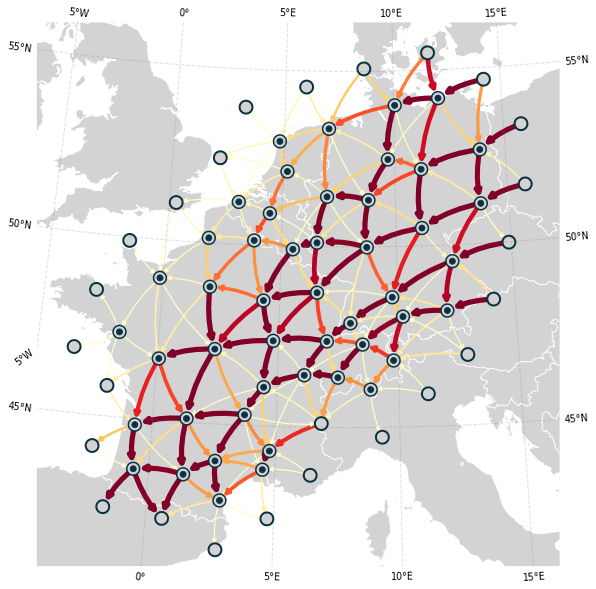

In [133]:
m = 'FluxGraphLSTM'

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["DejaVu Sans"], #["Helvetica"],
#     "font.size": 12})

prep_dir = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=25/abm/fall/2017'
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values


d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw = {'projection' : crs})
extent = [-4, 16, 41, 56]
ax.set_extent(extent)
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)

G_new = nx.read_gpickle(osp.join(base_dir, 'FluxRGNN', 'test_2017', 'final', 'performance_evaluation', '1-24', f'gt_fluxes.gpickle'))
    
crs=crs.proj4_init
max_flux = 100
bird_scale = 1
cbar = False

coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                     observed = voronoi.observed,
                                 geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]), 
                                crs='epsg:4326').to_crs(crs)
pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
       (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
#     pos = {ridx: (voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for 
#            (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
fluxes *= bird_scale
edge_widths = np.minimum(fluxes, max_flux) / (0.25 * max_flux) + 1.2

c_radar = 'lightgray' #'#999999' # '#347B98' '#0a3142' #'#4A7BB7' # '#0086b3'
c_marker = '#0a3142'
node_colors = ['#999999' if 'boundary' in n_data['radar'] else c_radar for n, n_data in G_new.nodes(data=True)]
node_colors = [c_radar for n, n_data in G_new.nodes(data=True)]

cmap = cm.get_cmap('YlOrRd')

#max_flux = max(max_flux, fluxes.max())
norm = plt.Normalize(0, max_flux)
#print(fluxes.min(), fluxes.max())
#print(nx.get_edge_attributes(G_new, 'flux'))
edge_colors = cmap(norm(fluxes))

if ax is None:
    fig, ax = plt.subplots(figsize=(9,7))
options = {
    'arrowsize': 30,
}
nx.draw(G_new, pos=pos, with_labels=False, node_size=9000/len(G_new), node_color=node_colors, ax=ax, 
        options={'arrowsize': edge_widths*200}, connectionstyle="arc3,rad=0.1", 
              edge_color=edge_colors, width=edge_widths, zorder=2)
#     nx.draw_networkx_edges(G_new, pos=pos, connectionstyle="arc3,rad=0.1", 
#                   edge_color=edge_colors, width=edge_widths)#, arrowsize=edge_widths*100)

gplt.polyplot(coord_df.query('observed == 1').buffer(20_000).to_crs(epsg=4326), ax=ax, extent=extent, zorder=3, edgecolor=c_marker, linewidth=1.5)
gplt.polyplot(coord_df.query('observed == 0').buffer(20_000).to_crs(epsg=4326), ax=ax, extent=extent, zorder=3, edgecolor=c_marker, linewidth=2)
gplt.pointplot(coord_df.query('observed == 1').to_crs(epsg=4326), ax=ax, extent=extent, zorder=4, color=c_marker, s=6)


if cbar:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, extend='max')
    cbar.set_label(label=r'net migratory flux [birds per 24h]',size=18, labelpad=5)
    cbar.ax.tick_params(labelsize=12) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing

ax.set_extent(extent)

#fig.tight_layout()

fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', 'abm_avg_gt_24h_fluxes.png'), bbox_inches='tight', dpi=200)

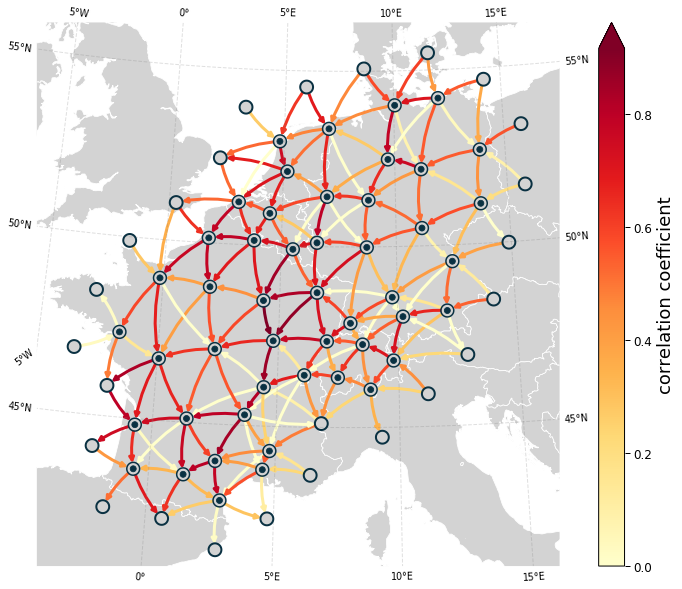

In [80]:
m = 'FluxGraphLSTM'


prep_dir = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=25/abm/fall/2017'
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values


d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw = {'projection' : crs})
extent = [-4, 16, 41, 56]
ax.set_extent(extent)
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)

G_new = nx.read_gpickle(osp.join(base_dir, 'FluxRGNN', 'test_2017', 'final', 'performance_evaluation', '1-24', f'flux_corr_1.gpickle')) 
crs=crs.proj4_init
cbar = True

coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                     observed = voronoi.observed,
                                 geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]), 
                                crs='epsg:4326').to_crs(crs)
pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
       (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
#     pos = {ridx: (voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for 
#            (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

corr = np.array(list(nx.get_edge_attributes(G_new,'corr').values()))
corr = np.nan_to_num(corr)
edge_widths = 3

c_radar = 'lightgray' #'#999999' # '#347B98' '#0a3142' #'#4A7BB7' # '#0086b3'
c_marker = '#0a3142'
node_colors = ['#999999' if 'boundary' in n_data['radar'] else c_radar for n, n_data in G_new.nodes(data=True)]
node_colors = [c_radar for n, n_data in G_new.nodes(data=True)]

cmap = cm.get_cmap('YlOrRd')

#max_flux = max(max_flux, fluxes.max())
norm = plt.Normalize(0, corr.max())
#print(fluxes.min(), fluxes.max())
#print(nx.get_edge_attributes(G_new, 'flux'))
edge_colors = cmap(norm(corr))

if ax is None:
    fig, ax = plt.subplots(figsize=(9,7))
options = {
    'arrowsize': 30,
}
nx.draw(G_new, pos=pos, with_labels=False, node_size=9000/len(G_new), node_color=node_colors, ax=ax, 
        options={'arrowsize': edge_widths*200}, connectionstyle="arc3,rad=0.1", 
              edge_color=edge_colors, width=edge_widths, zorder=2)

gplt.polyplot(coord_df.query('observed == 1').buffer(20_000).to_crs(epsg=4326), ax=ax, extent=extent, zorder=3, edgecolor=c_marker, linewidth=1.5)
gplt.polyplot(coord_df.query('observed == 0').buffer(20_000).to_crs(epsg=4326), ax=ax, extent=extent, zorder=3, edgecolor=c_marker, linewidth=2)
gplt.pointplot(coord_df.query('observed == 1').to_crs(epsg=4326), ax=ax, extent=extent, zorder=4, color=c_marker, s=6)


if cbar:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, extend='max')
    cbar.set_label(label=r'correlation coefficient',size=18, labelpad=5)
    cbar.ax.tick_params(labelsize=12) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing

ax.set_extent(extent)

#fig.tight_layout()

#fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', 'abm_gt_net_fluxes_final.png'), bbox_inches='tight', dpi=200)

Text(0.5, 1.0, 'Predicted migratory fluxes')

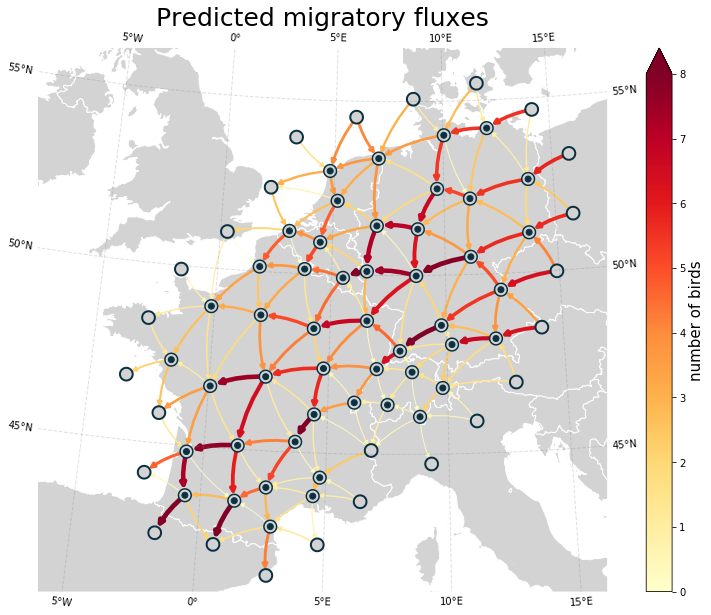

In [15]:
m = 'FluxGraphLSTM'

prep_dir = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=25/abm/fall/2015'
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values
G_path = osp.join(prep_dir, 'delaunay.gpickle')
G = nx.read_gpickle(G_path)

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw = {'projection' : crs})
extent = [-6, 16, 41, 56]
ax.set_extent(extent)
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
#gplt.polyplot(voronoi, ax=ax, edgecolor='darkgray', alpha=0.5, zorder=1)

#with open('/media/fiona/Seagate Basic/PhD/paper_1/results/abm/FluxGraphLSTM/test_2017/final_evaluation_128/trial_5/model_fluxes_fixedT0.pickle', 'rb') as f:
#    fluxes = pickle.load(f)

trial = 1
G_model, ax, max_flux = plot_fluxes(voronoi, G, fluxes['FluxRGNN'][1][trial], r['FluxRGNN'],
                         model=1, bird_scale=1, max_flux=8,
                        abm=False, ax=ax, crs=crs.proj4_init, net_fluxes=True)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing

ax.set_extent(extent)
ax.set_title('Predicted migratory fluxes', fontsize=25)

#fig.tight_layout()

#fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', 'abm_inferred_net_fluxes_map_poster.png'), bbox_inches='tight', dpi=200)

Text(0.5, 1.0, 'Predicted migratory fluxes')

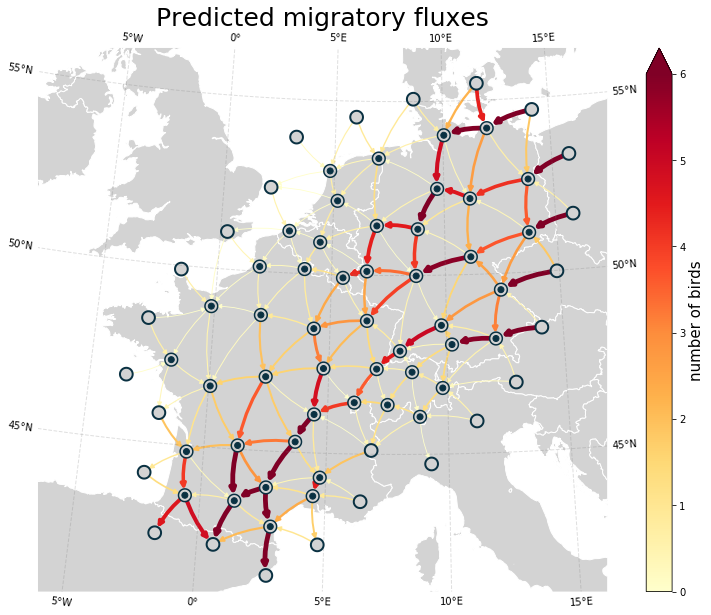

In [16]:
m = 'FluxGraphLSTM'

prep_dir = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=25/abm/fall/2017'
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values
G_path = osp.join(prep_dir, 'delaunay.gpickle')
G = nx.read_gpickle(G_path)

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw = {'projection' : crs})
extent = [-6, 16, 41, 56]
ax.set_extent(extent)
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
#gplt.polyplot(voronoi, ax=ax, edgecolor='darkgray', alpha=0.5, zorder=1)

#with open('/media/fiona/Seagate Basic/PhD/paper_1/results/abm/FluxGraphLSTM/test_2017/final_evaluation_128/trial_5/model_fluxes_fixedT0.pickle', 'rb') as f:
#    fluxes = pickle.load(f)

trial = 5
G_model, ax, max_flux = plot_fluxes(voronoi, G, fluxes['FluxRGNN'][1][trial], r['FluxRGNN'],
                         model=1, bird_scale=1, max_flux=6,
                        abm=False, ax=ax, crs=crs.proj4_init, net_fluxes=True)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing

ax.set_extent(extent)
ax.set_title('Predicted migratory fluxes', fontsize=25)

#fig.tight_layout()

#fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', 'abm_inferred_net_fluxes_map_poster.png'), bbox_inches='tight', dpi=200)

Text(0.5, 1.0, 'Predicted migratory fluxes')

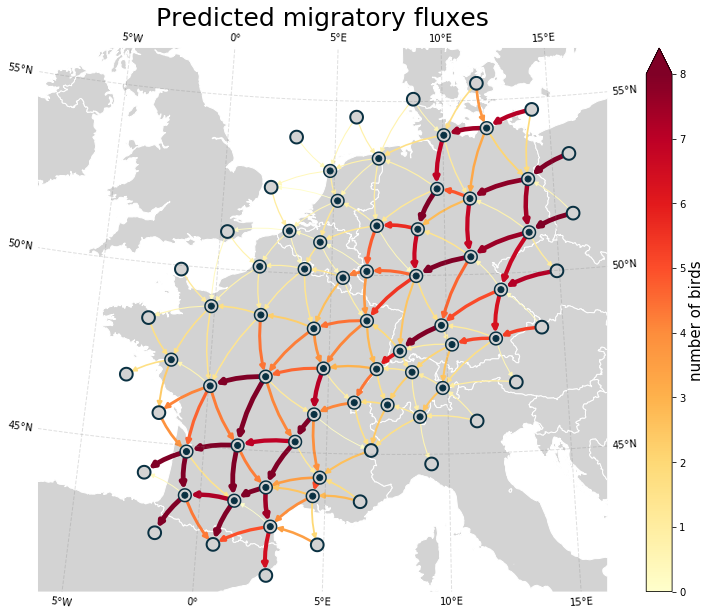

In [45]:
m = 'FluxGraphLSTM'

prep_dir = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=25/abm/fall/2017'
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values
G_path = osp.join(prep_dir, 'delaunay.gpickle')
G = nx.read_gpickle(G_path)

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw = {'projection' : crs})
extent = [-6, 16, 41, 56]
ax.set_extent(extent)
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
#gplt.polyplot(voronoi, ax=ax, edgecolor='darkgray', alpha=0.5, zorder=1)

#with open('/media/fiona/Seagate Basic/PhD/paper_1/results/abm/FluxGraphLSTM/test_2017/final_evaluation_128/trial_5/model_fluxes_fixedT0.pickle', 'rb') as f:
#    fluxes = pickle.load(f)

trial = 2
G_model, ax, max_flux = plot_fluxes(voronoi, G, fluxes['FluxGraphLSTM'][1][trial], r['FluxGraphLSTM'],
                         model=1, bird_scale=1, max_flux=8,
                        abm=False, ax=ax, crs=crs.proj4_init, net_fluxes=True)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing

ax.set_extent(extent)
ax.set_title('Predicted migratory fluxes', fontsize=25)

#fig.tight_layout()

#fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', 'abm_inferred_net_fluxes_map_poster.png'), bbox_inches='tight', dpi=200)

Text(0.5, 1.0, 'Predicted migratory fluxes')

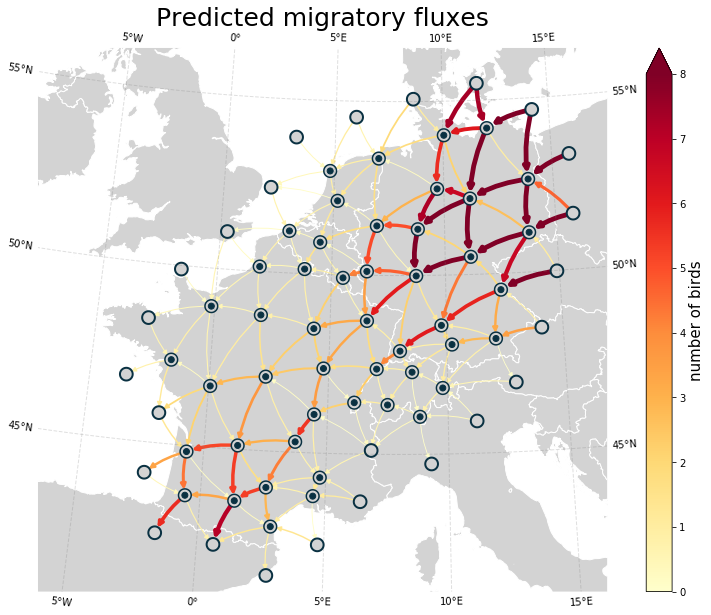

In [41]:
m = 'FluxGraphLSTM'

prep_dir = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=25/abm/fall/2017'
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values
G_path = osp.join(prep_dir, 'delaunay.gpickle')
G = nx.read_gpickle(G_path)

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw = {'projection' : crs})
extent = [-6, 16, 41, 56]
ax.set_extent(extent)
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
#gplt.polyplot(voronoi, ax=ax, edgecolor='darkgray', alpha=0.5, zorder=1)

#with open('/media/fiona/Seagate Basic/PhD/paper_1/results/abm/FluxGraphLSTM/test_2017/final_evaluation_128/trial_5/model_fluxes_fixedT0.pickle', 'rb') as f:
#    fluxes = pickle.load(f)
G_model, ax, max_flux = plot_fluxes(voronoi, G, fluxes['FluxGraphLSTM'][1][3], r['FluxGraphLSTM'],
                         model=1, bird_scale=1, max_flux=8,
                        abm=False, ax=ax, crs=crs.proj4_init, net_fluxes=True)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing

ax.set_extent(extent)
ax.set_title('Predicted migratory fluxes', fontsize=25)

#fig.tight_layout()

#fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', 'abm_inferred_net_fluxes_map_poster.png'), bbox_inches='tight', dpi=200)

## Verification of continuity assumption

In [65]:
cross_edges = 0
cross_birds = 0
total_birds = 0
for n1, n2, d in G_abm.edges(data=True):
    total_birds += d['flux']
    if not (n1, n2) in G_model.edges():
        cross_edges += 1
        cross_birds += d['flux']
print(f'number of cross edges: {cross_edges}')
print(f'number of birds flying between non-adjacent cells: {cross_birds}')
print(f'fraction of birds flying between non-adjacent cells: {cross_birds/total_birds}')


number of cross edges: 26
number of birds flying between non-adjacent cells: 3.374241504854369
fraction of birds flying between non-adjacent cells: 0.005929254659395081


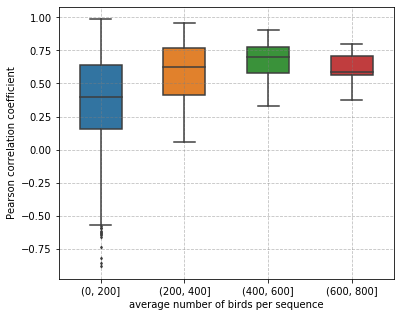

In [210]:
fig, ax = plt.subplots(figsize=(6,5))
sb.boxplot(x='gt_bin', y='source/sink', data=joint, width=0.5, fliersize=2, ax=ax)
#plt.xticks(rotation=45, ha='right')
ax.set(xlabel='average number of birds per sequence', ylabel='Pearson correlation coefficient')
plt.grid(color = 'gray', linestyle = '--', alpha=0.5);

fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', 'abm_source_sink_corr.png'), bbox_inches='tight', dpi=200)

In [236]:
delta_corr = pd.read_csv('/home/fiona/birdMigration/results/abm/FluxGraphLSTM/test_2017/test_new_weight_func_split_delta/performance_evaluation/delta_corr_per_hour.csv')

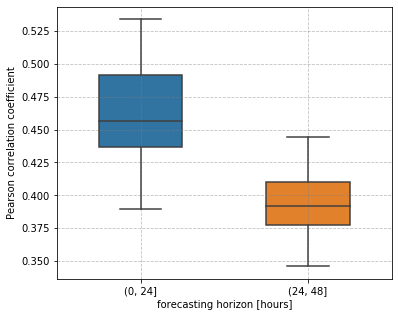

In [237]:
delta_corr['horizon'] = delta_corr['horizon'] - 24
delta_corr.dropna(inplace=True)
delta_corr['bin'] = pd.cut(delta_corr['horizon'], bins=np.arange(0, 64, 24))

fig, ax = plt.subplots(figsize=(6,5))
sb.boxplot(x='bin', y='source/sink', data=delta_corr, width=0.5, fliersize=2, ax=ax)
#plt.xticks(rotation=45, ha='right')
ax.set(xlabel='forecasting horizon [hours]', ylabel='Pearson correlation coefficient')
plt.grid(color = 'gray', linestyle = '--', alpha=0.5);
fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', 'abm_source_sink_corr_per_hour_bins.png'), bbox_inches='tight', dpi=200)